In [1]:
# Required libraries
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    r2_score,
    silhouette_score
)

In [2]:
# Create a data directory to store the synthetic datasets
DATA_DIR = './data/'
os.makedirs(DATA_DIR, exist_ok=True)

def create_synthetic_data(num_records, is_test=False):
    """
    Creates a synthetic dataset with the specified columns and characteristics.
    """
    np.random.seed(42)
    data = {
        'YEAR': 2008,
        'MONTH': np.random.choice(range(4, 9), num_records),
        'DAY': np.random.randint(1, 31, num_records),
        'ORDER': np.random.randint(1, 50, num_records),
        'COUNTRY': np.random.randint(1, 48, num_records),
        'SESSION_ID': np.arange(1000, 1000 + num_records),
        'PAGE_1_MAIN_CATEGORY': np.random.randint(1, 5, num_records),
        'PAGE_2_CLOTHING_MODEL': np.random.randint(1, 218, num_records),
        'COLOUR': np.random.randint(1, 15, num_records),
        'LOCATION': np.random.randint(1, 7, num_records),
        'MODEL_PHOTOGRAPHY': np.random.randint(1, 3, num_records),
        'PRICE': np.random.uniform(5, 500, num_records).round(2),
        'PRICE_2_HIGHER_THAN_AVG': np.random.choice([1, 2], num_records),
        'PAGE': np.random.randint(1, 6, num_records),
    }
    df = pd.DataFrame(data)
    
    # Introduce missing values as described in the problem statement
    for col in ['COUNTRY', 'PRICE']:
        df.loc[df.sample(frac=0.02).index, col] = np.nan
    
    # Create target variables
    df['PURCHASE_COMPLETED'] = np.where(
        (df['PRICE'] < 100) & (df['ORDER'] > 20) & (df['PAGE'] < 3), 1, 2
    )
    df['REVENUE'] = (df['PRICE'] * np.random.uniform(1.1, 1.5, num_records)).round(2)
    
    if is_test:
        df = df.drop(columns=['PURCHASE_COMPLETED', 'REVENUE'])
    
    return df

# Create and save the datasets
train_df = create_synthetic_data(num_records=10000)
test_df = create_synthetic_data(num_records=2000, is_test=True)
train_df.to_csv(os.path.join(DATA_DIR, 'train.csv'), index=False)
test_df.to_csv(os.path.join(DATA_DIR, 'test.csv'), index=False)

print("Synthetic datasets created successfully.")
print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Synthetic datasets created successfully.
Train data shape: (10000, 16)
Test data shape: (2000, 14)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2404\3925700477.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2404\3925700477.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

--- EDA: Initial Insights ---

Missing Values:
YEAR                       0
MONTH                      0
DAY                        0
ORDER                      0
COUNTRY                    0
SESSION_ID                 0
PAGE_1_MAIN_CATEGORY       0
PAGE_2_CLOTHING_MODEL      0
COLOUR                     0
LOCATION                   0
MODEL_PHOTOGRAPHY          0
PRICE                      0
PRICE_2_HIGHER_THAN_AVG    0
PAGE                       0
PURCHASE_COMPLETED         0
REVENUE                    0
DATE                       0
DAY_OF_WEEK                0
dtype: int64

Purchase vs. No Purchase Distribution:
PURCHASE_COMPLETED
2    9585
1     415
Name: count, dtype: int64


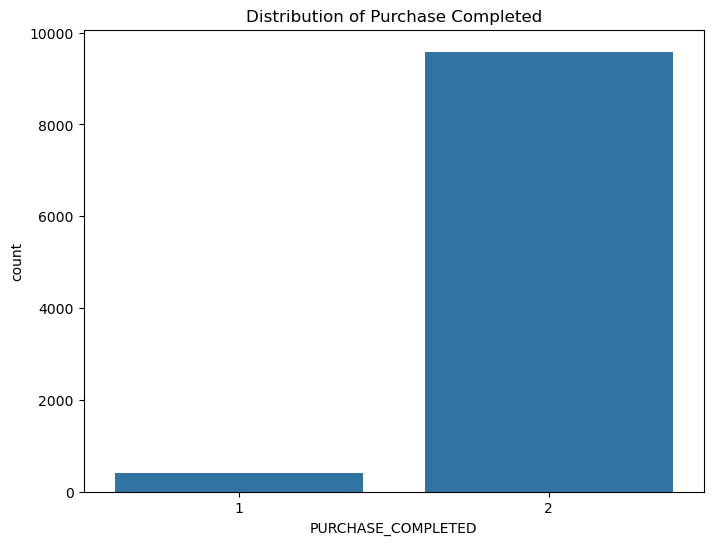

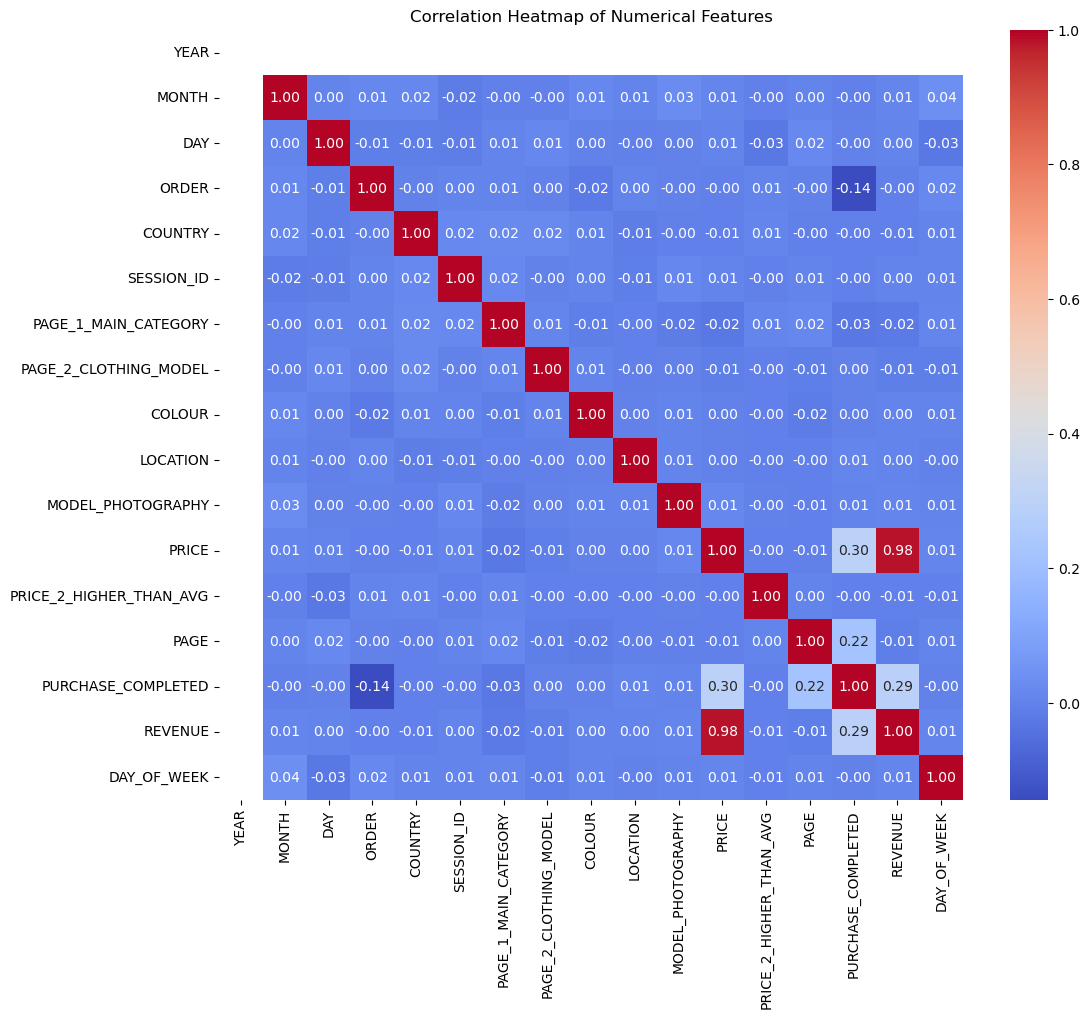

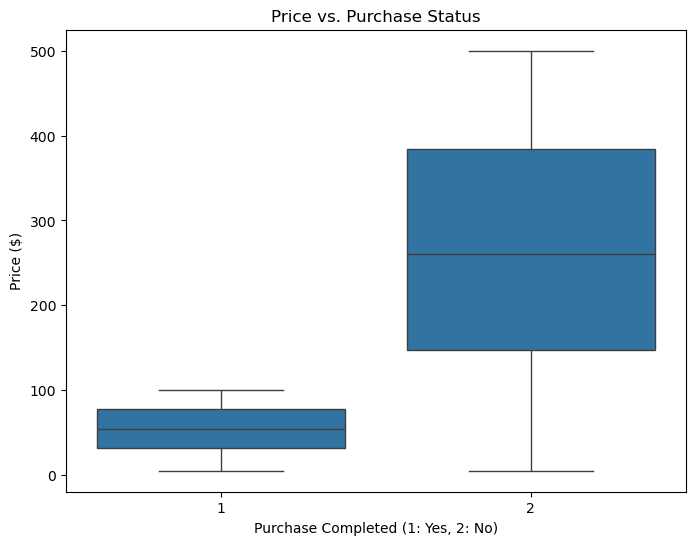

In [3]:
# Handle missing values as per the document's guidance[cite: 21, 22].
for col in ['PRICE', 'REVENUE']:
    train_df[col].fillna(train_df[col].median(), inplace=True)
for col in ['COUNTRY', 'PURCHASE_COMPLETED']:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Feature Engineering
# Extract 'DAY_OF_WEEK' from the date variables, which can impact user behavior[cite: 35].
train_df['DATE'] = pd.to_datetime(train_df[['YEAR', 'MONTH', 'DAY']])
train_df['DAY_OF_WEEK'] = train_df['DATE'].dt.dayofweek

# --- Exploratory Data Analysis (EDA) ---
print("--- EDA: Initial Insights ---")
print("\nMissing Values:")
print(train_df.isnull().sum())

print("\nPurchase vs. No Purchase Distribution:")
purchase_counts = train_df['PURCHASE_COMPLETED'].value_counts()
print(purchase_counts)

# Plotting distribution of the target variable for classification
plt.figure(figsize=(8, 6))
sns.countplot(x='PURCHASE_COMPLETED', data=train_df)
plt.title("Distribution of Purchase Completed")
plt.show()

# Correlation analysis with a heatmap
plt.figure(figsize=(12, 10))
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(train_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Box plot showing relationship between price and conversion
plt.figure(figsize=(8, 6))
sns.boxplot(x='PURCHASE_COMPLETED', y='PRICE', data=train_df)
plt.title("Price vs. Purchase Status")
plt.xlabel("Purchase Completed (1: Yes, 2: No)")
plt.ylabel("Price ($)")
plt.show()

In [4]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans

# Define the data directory to ensure the cell can run independently.
DATA_DIR = './data/'

# Load the data again to ensure the DataFrame is available
# NOTE: In a normal workflow, you would just run cells 3 and 4 first.
# This line is added for robustness in case the cells are run out of order.
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

# Handle missing values as per the document's guidance.
for col in ['PRICE', 'REVENUE']:
    train_df[col].fillna(train_df[col].median(), inplace=True)
for col in ['COUNTRY', 'PURCHASE_COMPLETED']:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# Feature Engineering
# Extract 'DAY_OF_WEEK' from the date variables.
train_df['DATE'] = pd.to_datetime(train_df[['YEAR', 'MONTH', 'DAY']])
train_df['DAY_OF_WEEK'] = train_df['DATE'].dt.dayofweek

# Split data for supervised learning tasks
X = train_df.drop(columns=['PURCHASE_COMPLETED', 'REVENUE', 'YEAR', 'DATE'])
y_classification = train_df['PURCHASE_COMPLETED']
y_regression = train_df['REVENUE']

# Split the data into training and testing sets for evaluation
X_train, X_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42
)

# Define a preprocessor pipeline for all supervised models
numerical_features = ['ORDER', 'PRICE', 'PAGE', 'DAY_OF_WEEK']
categorical_features = ['COUNTRY', 'PAGE_1_MAIN_CATEGORY', 'COLOUR', 'LOCATION', 'MODEL_PHOTOGRAPHY', 'PRICE_2_HIGHER_THAN_AVG']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Define pipelines for each problem type
# 1. Classification Pipeline
cls_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

# 2. Regression Pipeline
reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 3. Unsupervised Learning (Clustering)
# We'll use a subset of features for clustering
clustering_features = ['ORDER', 'PRICE', 'PAGE_1_MAIN_CATEGORY', 'COLOUR']
X_clustering = train_df[clustering_features]

# Preprocess the clustering data separately
clustering_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['ORDER', 'PRICE']),
        ('cat', OneHotEncoder(), ['PAGE_1_MAIN_CATEGORY', 'COLOUR'])
    ],
    remainder='passthrough'
)
X_clustering_processed = clustering_preprocessor.fit_transform(X_clustering)

print("Pipelines and clustering data prepared.")

Pipelines and clustering data prepared.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2404\2279156367.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df[col].median(), inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2404\2279156367.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [5]:
import time
import pandas as pd # Re-import pandas for robustness, just in case
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    r2_score,
    silhouette_score
)

start_time = time.perf_counter()

# Train the Classification Model
cls_pipeline.fit(X_train, y_cls_train)
cls_preds = cls_pipeline.predict(X_test)
cls_probs = cls_pipeline.predict_proba(X_test)[:, 1] # Probability of class 1

# Train the Regression Model
reg_pipeline.fit(X_train, y_reg_train)
reg_preds = reg_pipeline.predict(X_test)

# Train the Clustering Model
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_clustering_processed)
train_df['Cluster'] = cluster_labels

end_time = time.perf_counter()
print(f"Total training time: {end_time - start_time:.4f} seconds.")

# Model Evaluation
print("\n--- Classification Model Metrics ---")
print(f"Accuracy: {accuracy_score(y_cls_test, cls_preds):.4f}")
print(f"Precision: {precision_score(y_cls_test, cls_preds, pos_label=1):.4f}")
print(f"Recall: {recall_score(y_cls_test, cls_preds, pos_label=1):.4f}")
print(f"F1-Score: {f1_score(y_cls_test, cls_preds, pos_label=1):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_cls_test, cls_probs):.4f}")

print("\n--- Regression Model Metrics ---")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_reg_test, reg_preds):.4f}")
print(f"R-squared (R2): {r2_score(y_reg_test, reg_preds):.4f}")

print("\n--- Clustering Model Metrics ---")
print(f"Silhouette Score: {silhouette_score(X_clustering_processed, cluster_labels):.4f}")

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Total training time: 1.5597 seconds.

--- Classification Model Metrics ---
Accuracy: 0.9350
Precision: 0.3600
Recall: 0.9730
F1-Score: 0.5255
ROC-AUC Score: 0.9848

--- Regression Model Metrics ---
Mean Squared Error (MSE): 1138.6204
R-squared (R2): 0.9662

--- Clustering Model Metrics ---
Silhouette Score: 0.1704
